# Prediction of the function development using RNNs and its comparsion with other NNs

In this work I would like to use various neural network models to predict future price of BTC based on various cryptocurrency prices.  

### Importing libraries

I am going to use tensorflow and other libraries.

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
import glob

In [3]:
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.grid'] = False

#### parameters

In [182]:
RATIO_TO_PREDICT = "BTCBUSD"
FUTURE_PERIOD_PREDICT = 2

## Loading data

#### Downloaded data
I downloaded dataset from: https://pythonprogramming.net/static/downloads/machine-learning-data/crypto_data.zip. It contains 4 separate files with 5 columns for BTC, LTC, ETH and BCH. I am going to use only close price column. Code below extracts mecessary data from those files and creates pandas dataframe from it.

This code loops through ratios and loads the whole file into dataframe. Before adding that dataframe to our main dataframe which is called main_df we will drop unnecessary and only keep close price.

In [5]:
main_df = pd.DataFrame()

ratios = ["BTC-USD", "LTC-USD","ETH-USD","BCH-USD"]

for ratio in ratios:
    dataset = "crypto_data/"+ratio+".csv"
    df = pd.read_csv(dataset, names=["time","low","high","open","close","volume"])
    
    df.rename(columns={"close": f"{ratio}_close"}, inplace=True)
    
    df.set_index("time", inplace=True)
    df = df[[f"{ratio}_close"]]
    
    if len(main_df) == 0:
        main_df = df
    else:
        main_df = main_df.join(df)


Because there are some NaN values we will get rid of them using code below.

In [6]:
main_df = main_df.dropna()

Here we can see how main_df. It contains 5 columns from which we will be using only close prices.

In [7]:
main_df

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
time,,,,
1528968720,6487.379883,96.660004,486.010010,870.859985
1528968780,6479.410156,96.570000,486.000000,870.099976
1528968840,6479.410156,96.500000,485.750000,870.789978
1528968900,6479.979980,96.389999,486.000000,870.000000
1528968960,6480.000000,96.519997,486.000000,869.989990
...,...,...,...,...
1535214960,6713.140137,58.020000,279.359985,531.479980
1535215020,6714.520020,58.009998,279.359985,531.479980
1535215080,6714.520020,58.020000,279.369995,531.469971


To have better idea what our main dataframe represents we can plot our 4 prices using matplotlib

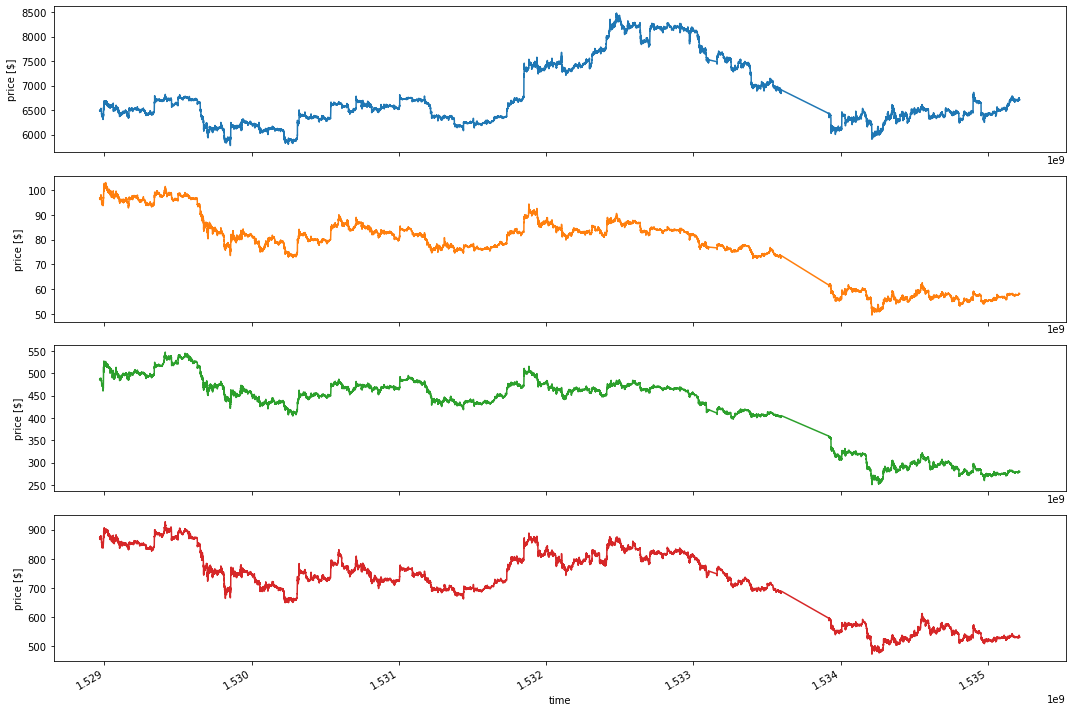

In [8]:
main_df.plot(subplots=True, legend = False, xlabel="time", ylabel="price [$]")
plt.tight_layout()
plt.show()

As we can see, there is a problematic part in our df in two thirds of the lenght.
I will cut the dataframe to exclude that data.

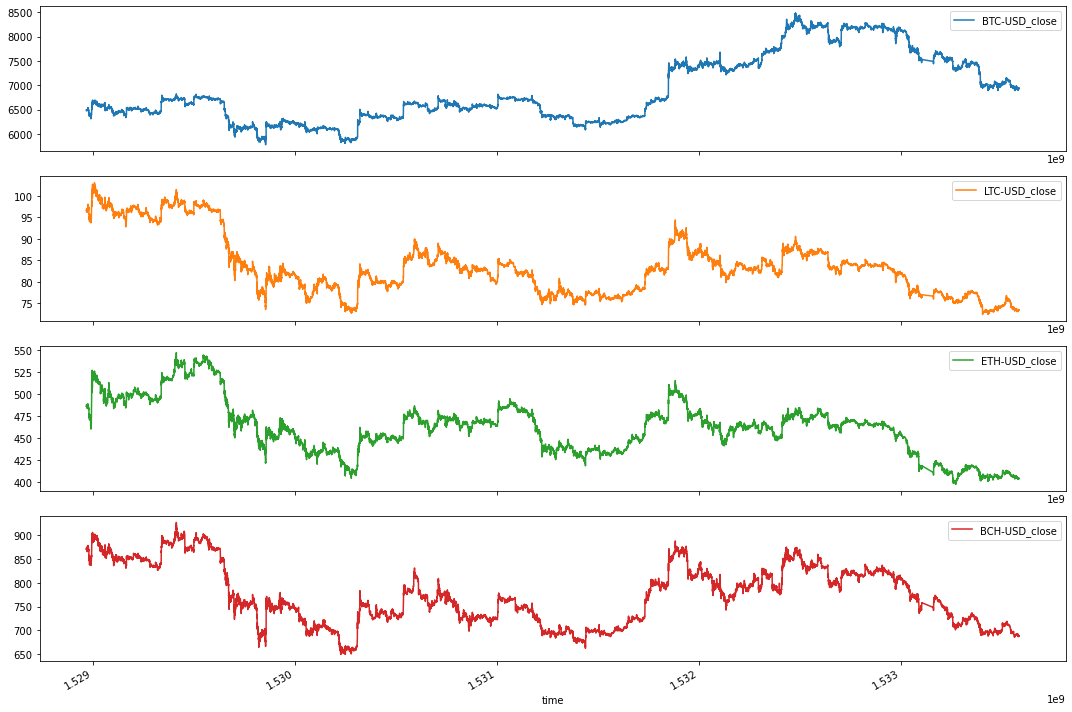

In [9]:
n = int(len(main_df)*0.78)
main_df = main_df[:n]
main_df.plot(subplots=True)
plt.tight_layout()
plt.show()

Another very useful function to use when exploring datasets is describe().

In [10]:
main_df.describe()

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
count,67171.000000,67171.000000,67171.000000,67171.000000
mean,6870.308763,83.741700,462.141509,774.064844
std,683.181276,6.889541,30.659425,62.814744
min,5778.109863,72.400002,397.299988,649.619995
25%,6350.629883,78.260002,439.820007,722.890015
50%,6638.160156,82.830002,464.010010,766.309998
75%,7417.705078,86.559998,476.429993,824.474976
max,8482.799805,103.040001,547.000000,927.000000


Some more info with .info()

In [11]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67171 entries, 1528968720 to 1533583920
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BTC-USD_close  67171 non-null  float64
 1   LTC-USD_close  67171 non-null  float64
 2   ETH-USD_close  67171 non-null  float64
 3   BCH-USD_close  67171 non-null  float64
dtypes: float64(4)
memory usage: 2.6 MB


#### Created data

This part explores data  I have been collecting.

In [52]:
path = 'crypto_data/my_dataset_csv.csv'               

my_df = pd.read_csv(path)  
my_df.fillna(method="ffill", inplace=True)

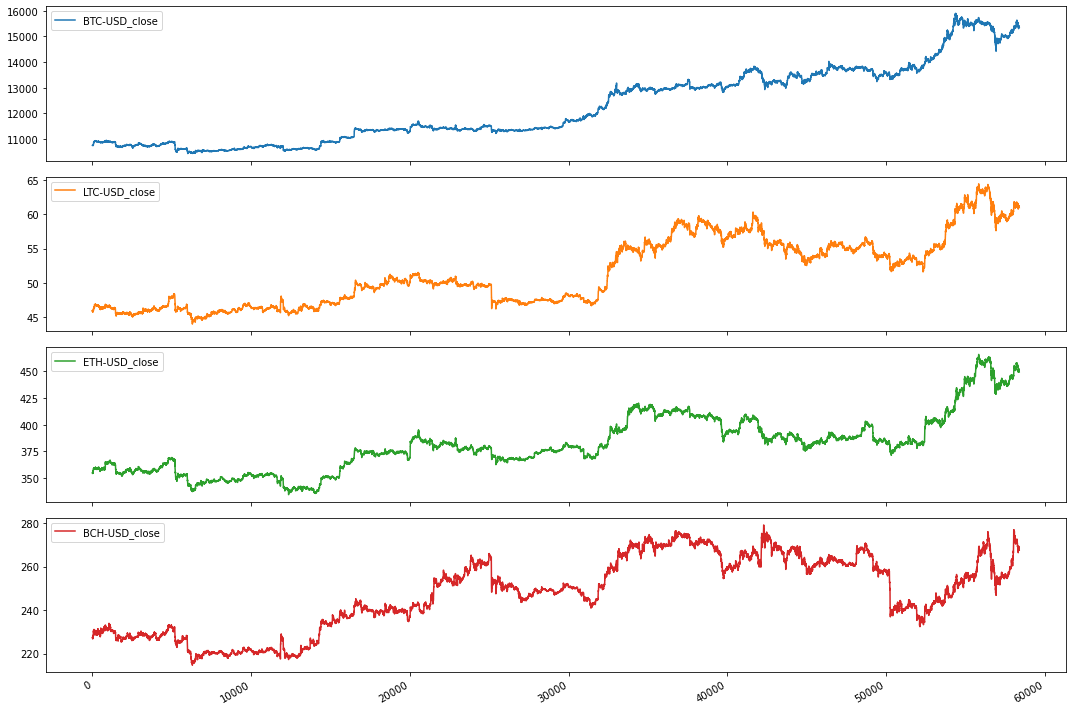

In [53]:
my_df.plot(subplots=True)
plt.tight_layout()
plt.show()

In [14]:
my_df = my_df.drop('Datetime', 1)

In [15]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52645 entries, 0 to 58392
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BTC-USD_close  52645 non-null  float64
 1   LTC-USD_close  52645 non-null  float64
 2   ETH-USD_close  52645 non-null  float64
 3   BCH-USD_close  52645 non-null  float64
dtypes: float64(4)
memory usage: 2.0 MB


In [16]:
my_df.describe()

,BTC-USD_close,LTC-USD_close,ETH-USD_close,BCH-USD_close
count,52645.000000,52645.000000,52645.000000,52645.000000
mean,12131.844154,51.026194,379.517847,246.143013
std,1426.934597,4.834474,25.994752,16.733452
min,10440.311520,44.019604,334.545563,214.629974
25%,10884.137700,46.781258,358.700684,230.689529
50%,11448.894530,49.727325,377.165222,247.441940
75%,13228.611330,55.042225,391.533630,260.743866
max,15902.977540,64.402084,465.675476,279.121887


#### Data from binance

Data obtained from binance

In [427]:
binance_df = pd.DataFrame()

binance_symbols = ["BTCBUSD", "ETHBUSD", "XRPBUSD", "BCHBUSD", "LTCBUSD", "XLMBUSD", "ADABUSD"]

for ratio in binance_symbols:
    
    dataset = "crypto_data/"+ratio+"-1m-data.csv"
    df = pd.read_csv(dataset, index_col="timestamp")
    df.rename(columns={"close": f"{ratio}_close"}, inplace=True)

    df = df[[f"{ratio}_close"]]
    df = df[:568700]
    
    
    if len(binance_df) == 0:
        binance_df = df
    else:
        binance_df = binance_df.join(df, on='timestamp')

XRP has a bad correlation with other data that is why I will drop it

In [428]:
binance_df = binance_df.drop('XRPBUSD_close', 1) 

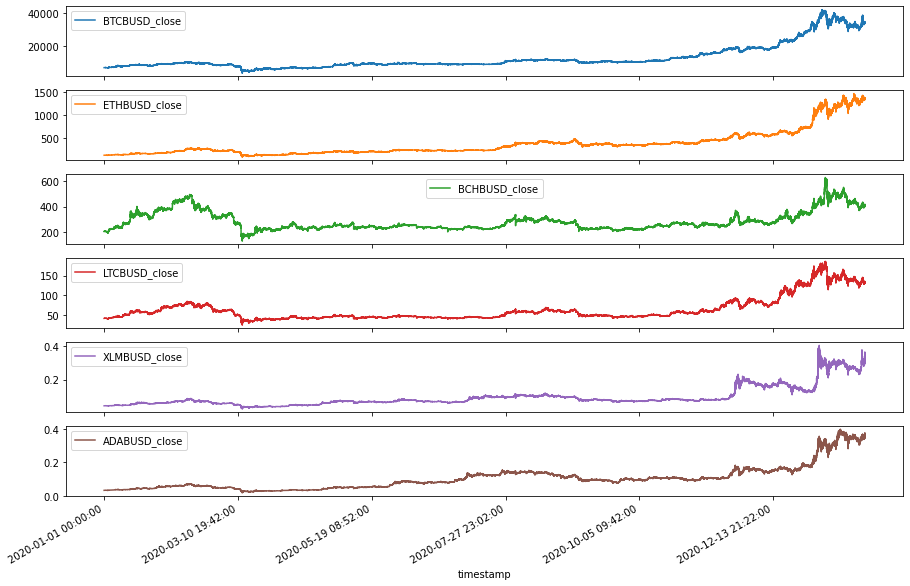

In [376]:
binance_df.plot(subplots=True)
plt.show()

In [377]:
binance_df_percentage = np.log(binance_df)

## Splitting data
It is common to split datasets into 3 parts. One is called training set and is uset for training our models. Another part is called validation set and after trainig we evaluate our model using this set and eventually change our model settings. After our model is done we will chceck results on thirs set which is calles test set. This last set is supposed to be uknown for our model so it should behave like "real world" data. We should pick model which does the best job with test set.

I will split main df into 3 parts with this ratio: (70%, 20%, 10%) train, validation, test.

In [378]:
def split_dataset(df):
    
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    
    return train_df, val_df, test_df

In [379]:
#column_indices = {name: i for i, name in enumerate(df.columns)}
num_features = main_df.shape[1]

In [381]:
train_df_d, val_df_d, test_df_d = split_dataset(binance_df_percentage) # !!!!!

In [382]:
train_df_my, val_df_my, test_df_my = split_dataset(my_df)

## Normalizing data
Our model could work even without normalizing, but it improves training ability and performance. My data has different scales, for that reason I need to normalize it.

##### Z-score

In [22]:
"""
from sklearn.preprocessing import StandardScaler
scaler_d = StandardScaler()  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

train_df_d = pd.DataFrame(scaler_d.fit_transform(train_df_d),columns = train_df_d.columns)
val_df_d = pd.DataFrame(scaler_d.transform(val_df_d),columns = val_df_d.columns)
test_df_d = pd.DataFrame(scaler_d.transform(test_df_d),columns = test_df_d.columns)

scaler_my = StandardScaler()

train_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)
"""

##### Min-max scaler.

In [160]:
"""
from sklearn.preprocessing import MinMaxScaler


scaler_d_min_max = MinMaxScaler()

train_df_d = pd.DataFrame(scaler_d_min_max.fit_transform(train_df_d),columns = train_df_d.columns)
val_df_d = pd.DataFrame(scaler_d_min_max.transform(val_df_d),columns = val_df_d.columns)
test_df_d = pd.DataFrame(scaler_d_min_max.transform(test_df_d),columns = test_df_d.columns)


scaler_my_min_max = MinMaxScaler()

train_df_my = pd.DataFrame(scaler_my_min_max.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler_my_min_max.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler_my_min_max.transform(test_df_my),columns = test_df_my.columns)
"""

'\nfrom sklearn.preprocessing import MinMaxScaler\n\n\nscaler_d_min_max = MinMaxScaler()\n\ntrain_df_d = pd.DataFrame(scaler_d_min_max.fit_transform(train_df_d),columns = train_df_d.columns)\nval_df_d = pd.DataFrame(scaler_d_min_max.transform(val_df_d),columns = val_df_d.columns)\ntest_df_d = pd.DataFrame(scaler_d_min_max.transform(test_df_d),columns = test_df_d.columns)\n\n\nscaler_my_min_max = MinMaxScaler()\n\ntrain_df_my = pd.DataFrame(scaler_my_min_max.fit_transform(train_df_my),columns = train_df_my.columns)\nval_df_my = pd.DataFrame(scaler_my_min_max.transform(val_df_my),columns = val_df_my.columns)\ntest_df_my = pd.DataFrame(scaler_my_min_max.transform(test_df_my),columns = test_df_my.columns)\n'

In [232]:
scaler_d = StandardScaler()

In [221]:
#binance_df_percentage = pd.DataFrame(scaler_d.fit_transform(binance_df_percentage),columns = binance_df_percentage.columns)

In [383]:
train_df_d = pd.DataFrame(scaler_d.fit_transform(train_df_d),columns = binance_df_percentage.columns)
val_df_d = pd.DataFrame(scaler_d.transform(val_df_d),columns = binance_df_percentage.columns)
test_df_d = pd.DataFrame(scaler_d.transform(test_df_d),columns = binance_df_percentage.columns)

<AxesSubplot:>

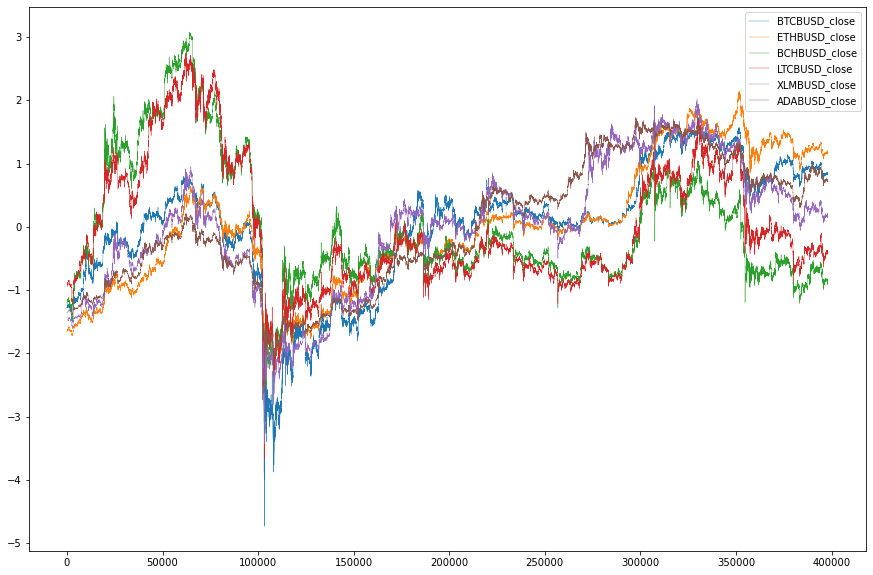

In [403]:
train_df_d.plot(linewidth=0.4)

<AxesSubplot:>

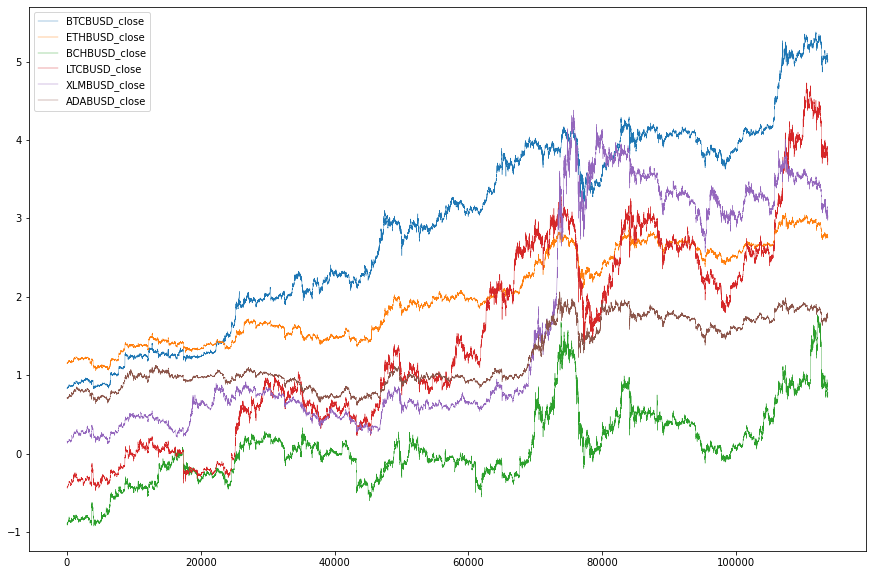

In [404]:
val_df_d.plot(linewidth=0.4)

<AxesSubplot:>

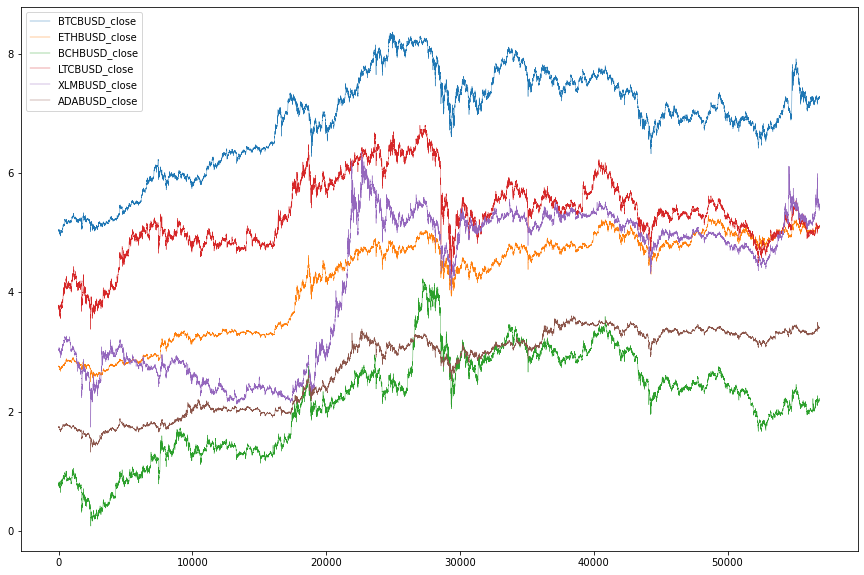

In [405]:
test_df_d.plot(linewidth=0.4)

### Data windowing

Models will make predictions using part of data called windows. 


In [384]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        # This part takes arguemntes and calculate window size
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        

        # Window size is equal to input width and shift
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) # slice(0, i_w, None)
        
        # np.arange(5) -> array([0, 1, 2, 3, 4])
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

Code below splits data inside window class into inputs and labels.
Inputs are data from which our model is supposed to predict label, 
which is the actual correct value.

In [385]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]   
    # (whole, input_slice, whole): (3, 12, 4) -> i_s=5 (3,5,4)
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [386]:
w2 = WindowGenerator(input_width=24, label_width=1, shift=2,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d, label_columns=['BTCBUSD_close'])
w2


Total window size: 26
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [25]
Label column name(s): ['BTCBUSD_close']

In [387]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df_d[:w2.total_window_size]),
                           np.array(train_df_d[100:100+w2.total_window_size]),
                           np.array(train_df_d[200:200+w2.total_window_size])])

In [388]:
example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 26, 6)
Inputs shape: (3, 24, 6)
labels shape: (3, 1, 1)


In [389]:
example_window.shape

TensorShape([3, 26, 6])

Simple vizualization of the split window with function plot().

In [390]:
w2.example = example_inputs, example_labels

In [391]:
def plot(self, model=None, plot_col=RATIO_TO_PREDICT+'_close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
        
    plt.xlabel('Time [min]')

WindowGenerator.plot = plot

In [392]:
def plot_input_data(self,  model=None):
    inputs, labels = self.example
    
    print(inputs)
    plot(inputs)
    
WindowGenerator.plot_input_data = plot_input_data

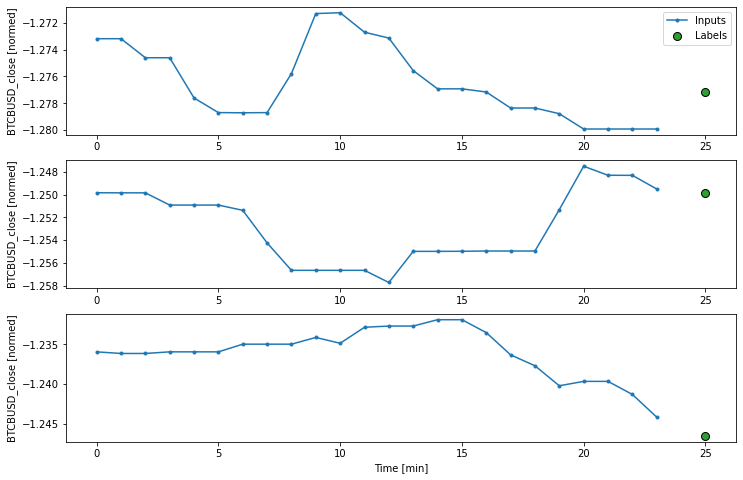

In [393]:
w2.plot()

#### Create dataset

Function below takes dataframe and converts it to tf.data.Dataset with (input_window, label_window) pairs.
First, we convert dataframe to np.array and then timeseries_dataset_from_array function converts it to dataset. 

In [394]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32) # convert data to np.array
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
      # very useful function which converts data to dataset (input_window, label_window) from array

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [395]:
@property  # https://www.python-course.eu/python3_properties.php
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

#### Define wide window

In [407]:
wide_window_d = WindowGenerator(
    input_width=24, label_width=24, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=[RATIO_TO_PREDICT+'_close'])

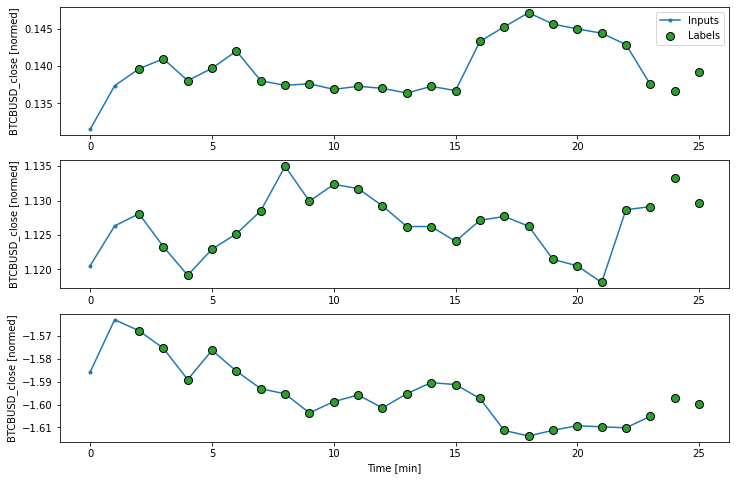

In [408]:
wide_window_d.plot()

In [409]:
wide_window_my = WindowGenerator(
    input_width=24, label_width=24, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_my,val_df = val_df_my, test_df = test_df_my,label_columns=[RATIO_TO_PREDICT+'_close'])

#### To compare prediction performances

In [410]:
val_performance = {}
performance = {}

## Models

MyModel class to make working with models easier. 

In [420]:
from tensorflow.keras.models import load_model

class MyModel():
    
    
    def __init__(self, model):
        self.model = model
        
    def load_model(self, dir_name):
        self.model = load_model(dir_name)
    
    def eval_mod(self, window, verbose):
        res = self.model.evaluate(window, verbose=verbose)
        print("Loss:", res[0], "MAE:", res[1])
        
    def save_model(self, name):
        self.model.save("percentage_change\\"+ name +".model")
        
    def retrain_model(self, window, patience, epochs):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)
        history = self.model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=[early_stopping])
        self.history = history
        
    def compile_and_fit(self, window, patience=3):

        ## callbacks list https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min', restore_best_weights=True)
        # https://github.com/Jaewan-Yun/optimizer-visualization
        # https://www.tensorflow.org/api_docs/python/tf/keras/Model
        opt = tf.optimizers.Adam()
        self.model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=opt,
                    metrics=[tf.metrics.MeanAbsoluteError()])

        history = self.model.fit(window.train, epochs=120,
                          validation_data=window.val,
                          callbacks=[early_stopping])
        return history


#### Training procedure
Because we will train more models let's create function which compiles and train desired model.

In [412]:
MAX_EPOCHS = 120

def compile_and_fit(model, window, patience=3):

    ## callbacks list https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min', restore_best_weights=True)

    # https://github.com/Jaewan-Yun/optimizer-visualization
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model
    opt = tf.optimizers.Adam()
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

To plot learning process there is a function below.

In [413]:
def plot_loss(history, graph_param):
    plt.plot(history.history[str(graph_param)], label=str(graph_param))
    plt.plot(history.history['val_'+ str(graph_param)], label='val_' + str(graph_param))
    plt.xlabel('Epoch')
    plt.ylabel(graph_param)
    plt.legend()
    plt.grid(True)

To save model I created function below.

In [414]:
def save_model(model, name):
    model.save("models_29_01_2021\\"+ name +".model")
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model#save
    """
    save(filepath, overwrite=True, include_optimizer=True, save_format=None,signatures=None, options=None)
    """

In [49]:
p

NameError: name 'p' is not defined

In [301]:
## Linear model

In [415]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

lin = MyModel(linear)
history = lin.compile_and_fit(wide_window_d)

Epoch 1/120
12440/12440 [==============================] - 26s 2ms/step - loss: 0.3638 - mean_absolute_error: 0.4680 - val_loss: 0.0781 - val_mean_absolute_error: 0.2350
Epoch 2/120
12440/12440 [==============================] - 25s 2ms/step - loss: 0.1325 - mean_absolute_error: 0.2806 - val_loss: 0.0479 - val_mean_absolute_error: 0.1851
Epoch 3/120
12440/12440 [==============================] - 25s 2ms/step - loss: 0.0961 - mean_absolute_error: 0.2552 - val_loss: 0.0452 - val_mean_absolute_error: 0.1835
Epoch 4/120
12440/12440 [==============================] - 25s 2ms/step - loss: 0.0820 - mean_absolute_error: 0.2429 - val_loss: 0.0455 - val_mean_absolute_error: 0.1848
Epoch 5/120
12440/12440 [==============================] - 25s 2ms/step - loss: 0.0741 - mean_absolute_error: 0.2332 - val_loss: 0.0459 - val_mean_absolute_error: 0.1858
Epoch 6/120
12440/12440 [==============================] - 25s 2ms/step - loss: 0.0684 - mean_absolute_error: 0.2247 - val_loss: 0.0460 - val_mean_abs

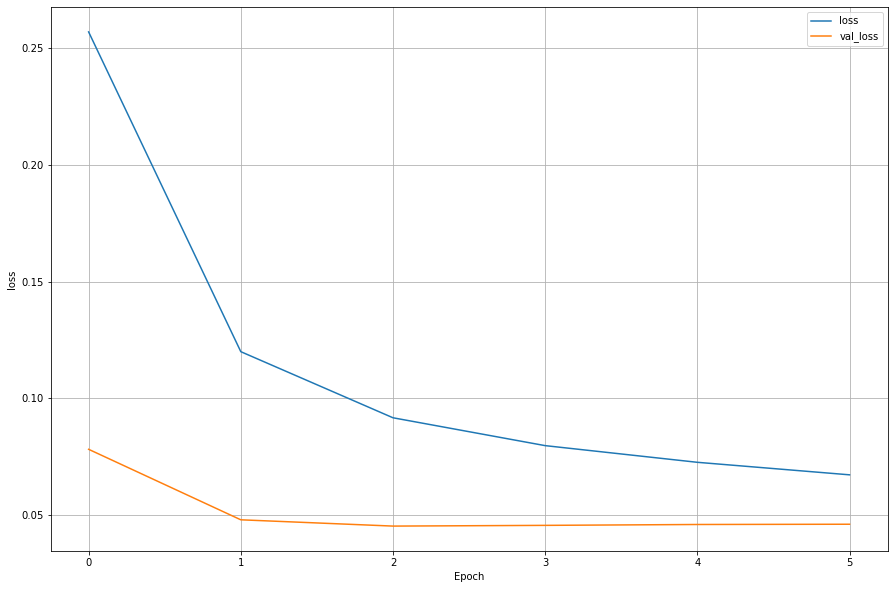

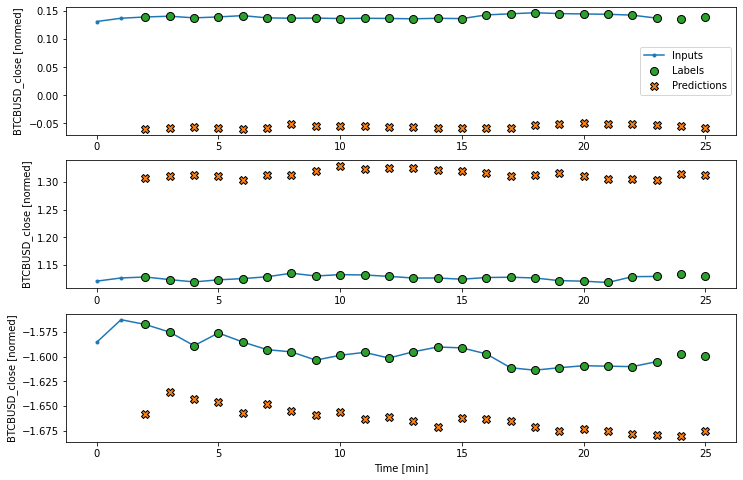

In [416]:
plot_loss(history, 'loss')
wide_window_d.plot(lin.model)

In [367]:
wide_window_d.plot_input_data(lin.model)

tf.Tensor(
[[[ 6.22145772e-01  4.77198511e-01  4.70023453e-01 -9.08487942e-04
   -1.52300869e-03 -2.43003387e-03]
  [ 2.26829518e-02  6.04662180e-01 -1.18621066e-01  1.21229410e+00
   -1.52300869e-03 -2.43003387e-03]
  [-1.24752194e-01 -2.41121976e-03 -9.69445100e-04 -9.08487942e-04
   -1.52300869e-03 -2.43003387e-03]
  ...
  [ 4.53315586e-01 -3.20926338e-01  4.68846828e-01 -9.08487942e-04
   -1.04789269e+00 -2.43003387e-03]
  [ 1.12664834e-01  6.66786969e-01  9.61365700e-01  1.05730414e+00
    1.33234918e+00 -2.43003387e-03]
  [-9.00128424e-01 -6.39110267e-01 -9.61692810e-01 -1.35933065e+00
   -1.52300869e-03 -2.43003387e-03]]

 [[-3.39958817e-01 -2.41121976e-03 -9.69445100e-04 -9.08487942e-04
   -1.52300869e-03 -2.43003387e-03]
  [-5.15618742e-01 -2.41121976e-03 -9.69445100e-04 -9.08487942e-04
   -1.52300869e-03 -2.43003387e-03]
  [ 2.37204835e-01 -2.41121976e-03 -2.32858992e+00 -9.08487942e-04
   -1.52300869e-03 -2.43003387e-03]
  ...
  [ 1.57577336e-01 -2.41121976e-03 -9.69445100e-

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'example'

### Recurrent neural network (LSTM)

[batch, timesteps, feature] 3D input

In [421]:
act = "tanh"
recurrent_act = "sigmoid"

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(16, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [422]:
lstm = MyModel(lstm_model)

In [423]:
history = lstm.compile_and_fit(wide_window_d)

Epoch 1/120
12440/12440 [==============================] - 134s 10ms/step - loss: 0.0191 - mean_absolute_error: 0.0404 - val_loss: 1.2511 - val_mean_absolute_error: 0.8292
Epoch 2/120
12440/12440 [==============================] - 127s 10ms/step - loss: 1.9445e-04 - mean_absolute_error: 0.0081 - val_loss: 0.9748 - val_mean_absolute_error: 0.7170
Epoch 3/120
12440/12440 [==============================] - 126s 10ms/step - loss: 1.4713e-04 - mean_absolute_error: 0.0072 - val_loss: 0.8281 - val_mean_absolute_error: 0.6538
Epoch 4/120
12440/12440 [==============================] - 127s 10ms/step - loss: 1.2774e-04 - mean_absolute_error: 0.0065 - val_loss: 0.8357 - val_mean_absolute_error: 0.6548
Epoch 5/120
12440/12440 [==============================] - 126s 10ms/step - loss: 1.1437e-04 - mean_absolute_error: 0.0063 - val_loss: 0.8518 - val_mean_absolute_error: 0.6663
Epoch 6/120
12440/12440 [==============================] - 127s 10ms/step - loss: 1.0424e-04 - mean_absolute_error: 0.0059 -

In [424]:
val_performance['LSTM'] = lstm.eval_mod(wide_window_d.val, verbose=1)
performance['LSTM'] = lstm.eval_mod(wide_window_d.test, verbose=1)

3554/3554 [==============================] - 21s 6ms/step - loss: 0.8281 - mean_absolute_error: 0.6538
Loss: 0.8281098008155823 MAE: 0.6537836194038391
1777/1777 [==============================] - 10s 6ms/step - loss: 16.6131 - mean_absolute_error: 3.9868
Loss: 16.613115310668945 MAE: 3.986788272857666


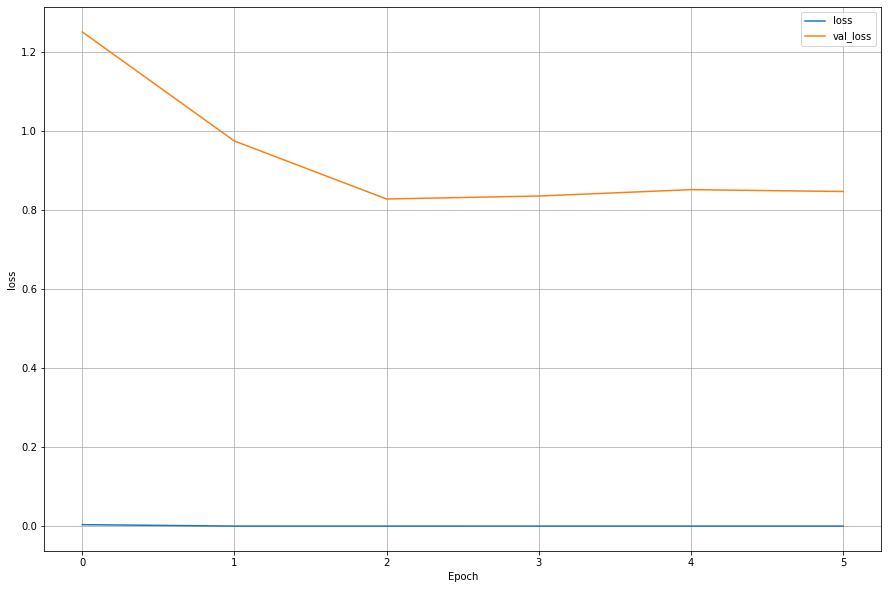

In [425]:
plot_loss(history, 'loss')

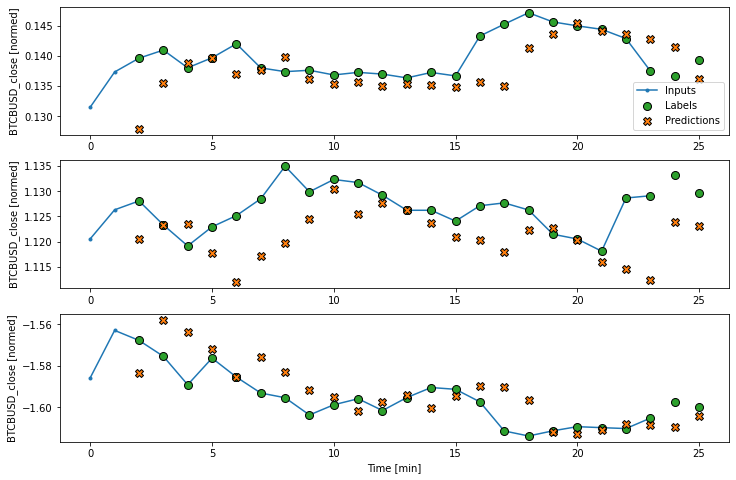

In [426]:
wide_window_d.plot(lstm.model)

In [211]:
lstm.save_model("32x4_16")

C:\Users\Admin\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\Users\Admin\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: models_retrained\32x4_16.model\assets


INFO:tensorflow:Assets written to: models_retrained\32x4_16.model\assets


In [214]:
lstm.model.save("percentage_change\\32x4_16.model")


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: percentage_change\32x4_16.model\assets


INFO:tensorflow:Assets written to: percentage_change\32x4_16.model\assets


In [215]:
tf.keras.models.save_model(lstm.model, "percentage_change\\32x4_16_copy.model")


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: percentage_change\32x4_16_copy.model\assets


INFO:tensorflow:Assets written to: percentage_change\32x4_16_copy.model\assets


#### Loading model

In [ ]:
lstm_model.summary()

### Recurrent neural network (LSTM - bidirectional)

Parameters from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

In [ ]:
lstm_model_bidirectional = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(16, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model_bidirectional, wide_window_d)

In [ ]:
val_performance['LSTM-bidi'] = lstm_model_bidirectional.evaluate(wide_window_d.val)
performance['LSTM-bidi'] = lstm_model_bidirectional.evaluate(wide_window_d.test, verbose=0)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
wide_window_d.plot(lstm_model_bidirectional)

In [ ]:
save_model(lstm_model_bidirectional, "lstm_bidi")

### Recurrent neural network (CNN - LSTM)

[samples, subsequences, timesteps, features]

https://keras.io/api/layers/recurrent_layers/time_distributed/


In [ ]:
"""
lstm_cnn_model = tf.keras.models.Sequential([
  
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=64, kernel_size=(CONV_WIDTH,), activation='relu')),
    tf.keras.layers.TimeDistributed(MaxPooling1D(pool_size=2)),
    tf.keras.layers.TimeDistributed(Flatten()),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(units=1)
])
"""

### Recurrent neural network (GRU)

Parameters from: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

In [ ]:
gru_model = tf.keras.models.Sequential([
  
    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(16, activation=act),
    tf.keras.layers.Dense(units=1)
])


In [ ]:
"""
Two minutes in the futeure
gru_model = tf.keras.models.Sequential([
  
    tf.keras.layers.GRU(128,  return_sequences=True),
    tf.keras.layers.GRU(256,  return_sequences=True),
    tf.keras.layers.GRU(256,  return_sequences=True),
    tf.keras.layers.GRU(64,  return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(units=1)
])

1469/1469 [==============================] - 298s 203ms/step - loss: 6.2745e-04 - mean_absolute_error: 0.0153 - val_loss: 8.5561e-04 - val_mean_absolute_error: 0.0185s

"""

In [ ]:
"""
One minute prediction
gru_model = tf.keras.models.Sequential([
  
    tf.keras.layers.GRU(128,  return_sequences=True),
    tf.keras.layers.GRU(256,  return_sequences=True),
    tf.keras.layers.GRU(128,  return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(units=1)
])

1469/1469 [==============================] - 165s 112ms/step - loss: 4.8618e-04 - mean_absolute_error: 0.0128 - val_loss: 4.0787e-04 - val_mean_absolute_error: 0.0117

"""

In [ ]:
"""
One minute prediction
gru_model = tf.keras.models.Sequential([
  
    tf.keras.layers.GRU(128,  return_sequences=True),
    tf.keras.layers.GRU(128,  return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(units=1)
])

420/420 [==============================] - 6s 14ms/step - loss: 4.1807e-04 - mean_absolute_error: 0.0123

"""

In [ ]:
history = compile_and_fit(gru_model, wide_window_d)

In [ ]:
val_performance['GRU'] = gru_model.evaluate(wide_window_d.val)
performance['GRU'] = gru_model.evaluate(wide_window_d.test, verbose=0)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
wide_window_d.plot(gru_model)

In [ ]:
save_model(gru_model, "gru_model")

### Recurrent neural network (GRU - bidirectional)

In [ ]:
gru_model_bidirectional = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(16, activation=act),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(gru_model_bidirectional, wide_window_d)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
val_performance['GRU-bidi'] = gru_model_bidirectional.evaluate(wide_window_d.val)
performance['GRU-bidi'] = gru_model_bidirectional.evaluate(wide_window_d.test, verbose=0)

In [ ]:
wide_window_d.plot(gru_model_bidirectional)

In [ ]:
save_model(gru_model_bidirectional, "gru_model_bidi")

### Performance

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [BTC-USD, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

### Load and retrain model

In [ ]:
#gru_bidi_loaded = LoadedModel("models_retrained\\gru_bidi.model")

In [ ]:
#eval_mod(self, window, verbose):

In [ ]:
#gru_bidi_loaded.eval_mod(wide_window_my.train, 0)

In [ ]:
#gru_bidi_loaded.eval_mod(wide_window_d.test, 0)

In [ ]:
#gru_bidi_loaded.retrain_model(patience=2, epochs=5, window=wide_window_my)

In [ ]:
#plot_loss(gru_bidi_loaded.history, 'loss')

In [ ]:
#gru_bidi_loaded.eval_mod(wide_window_d.test, 0)

In [ ]:
#gru_bidi_loaded.save_model("gru_bidi")

In [ ]:
#retrain_model(self, patience, epochs, window):

In [ ]:
#res = model_loaded.evaluate(wide_window_my.train)

In [ ]:
#model_loaded = load_model("models_first\\gru_bidi.model")


In [ ]:
#model_loaded.evaluate(wide_window_d.test)

In [ ]:
#res[1]

## Single shot models
The entire sequence prediction in a single step.

24 min to the future with 2 min to the future

In [ ]:
OUT_STEPS = 1
wide_window_d_single = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=[RATIO_TO_PREDICT+'_close'])

wide_window_my_single = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_my,val_df = val_df_my, test_df = test_df_my,label_columns=[RATIO_TO_PREDICT+'_close'])



In [ ]:
wide_window_my_single.plot()

In [ ]:
single_val_performance = {}
single_performance = {}

### LSTM single shot

In [ ]:
"""
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(1, kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
   # tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
sigmoid activation bad
"""

In [ ]:
lstm_model_single = tf.keras.Sequential([
    
    tf.keras.layers.LSTM(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(32, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(16, activation=act),
    tf.keras.layers.Dense(units=1)
    
])


In [ ]:
history = compile_and_fit(lstm_model_single, wide_window_d_single)

In [ ]:
single_val_performance['LSTM_single'] = lstm_model_single.evaluate(wide_window_d_single.val)
single_performance['LSTM_single'] = lstm_model_single.evaluate(wide_window_d_single.test, verbose=1)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
save_model(lstm_model_single, "lstm_single")

### LSTM Bidirectional single shot

In [ ]:
lstm_model_bidirectional_single = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(16, activation=act),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model_bidirectional_single, wide_window_d_single)

In [ ]:
single_val_performance['LSTM_bidi_single'] = lstm_model_bidirectional_single.evaluate(wide_window_d_single.val)
single_performance['LSTM_bidi_single'] = lstm_model_bidirectional_single.evaluate(wide_window_d_single.test, verbose=0)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
save_model(lstm_model_bidirectional_single, "lstm_bidi_single")

### GRU single shot

In [ ]:
gru_model_single_shot = tf.keras.models.Sequential([

    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(32, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(16, activation=act),
    tf.keras.layers.Dense(units=1)
    
])


In [ ]:
history = compile_and_fit(gru_model_single_shot, wide_window_d_single)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
single_val_performance['GRU_single'] = gru_model_single_shot.evaluate(wide_window_d_single.val)
single_performance['GRU_single'] = gru_model_single_shot.evaluate(wide_window_d_single.test, verbose=0)

In [ ]:
save_model(gru_model_single_shot, "gru_single")

### GRU Bidirectional single shot

In [ ]:
gru_model_bidirectional_single = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(16, activation=act),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(gru_model_bidirectional_single, wide_window_d_single)

In [ ]:
single_val_performance['GRU_bidi_single'] = gru_model_bidirectional_single.evaluate(wide_window_d_single.val)
single_performance['GRU_bidi_single'] = gru_model_bidirectional_single.evaluate(wide_window_d_single.test, verbose=0)

In [ ]:
plot_loss(history, 'loss')

In [ ]:
save_model(gru_model_bidirectional_single, "gru_bidi_single")

### Autoregressive model

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

In [ ]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model_single.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

### Evaluating loaded models

In [ ]:
loaded_model = LoadedModel("models_29_01_2021\\lstm.model")

In [ ]:
loaded_model.eval_mod(wide_window_d.val, 0)

In [ ]:
loaded_model.eval_mod(wide_window_d.test, 0)

In [ ]:
loaded_model.eval_mod(wide_window_my.test, 0)

In [ ]:
loaded_model_single = LoadedModel("models_29_01_2021\\gru_bidi_single.model")

In [ ]:
loaded_model_single.eval_mod(wide_window_d_single.val, 0)

In [ ]:
loaded_model_single.eval_mod(wide_window_d_single.test, 0)

In [ ]:
loaded_model_single.eval_mod(wide_window_my_single.test, 0)